Data Loading and Exploration

In [61]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load the dataset
data = pd.read_csv(r"datasets\raw.csv")

# Display the first few rows
print(data.head())

# Get information about the dataset
print(data.info())

# Generate descriptive statistics
print(data.describe())

   Square_Footage  Num_Bedrooms  Num_Bathrooms  Year_Built  Lot_Size  \
0            1360             2              1        1981  0.599637   
1            4272             3              3        2016  4.753014   
2            3592             1              2        2016  3.634823   
3             966             1              2        1977  2.730667   
4            4926             2              1        1993  4.699073   

   Garage_Size Neighborhood_Quality   House_Price  
0            0              Average  2.623829e+05  
1            1              Average  9.852609e+05  
2            0            Excellent  7.779774e+05  
3            1                 Good  2.296989e+05  
4            0                 Good  1.041741e+06  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Square_Footage        1000 non-null   int64

Exploring the Data Distribution

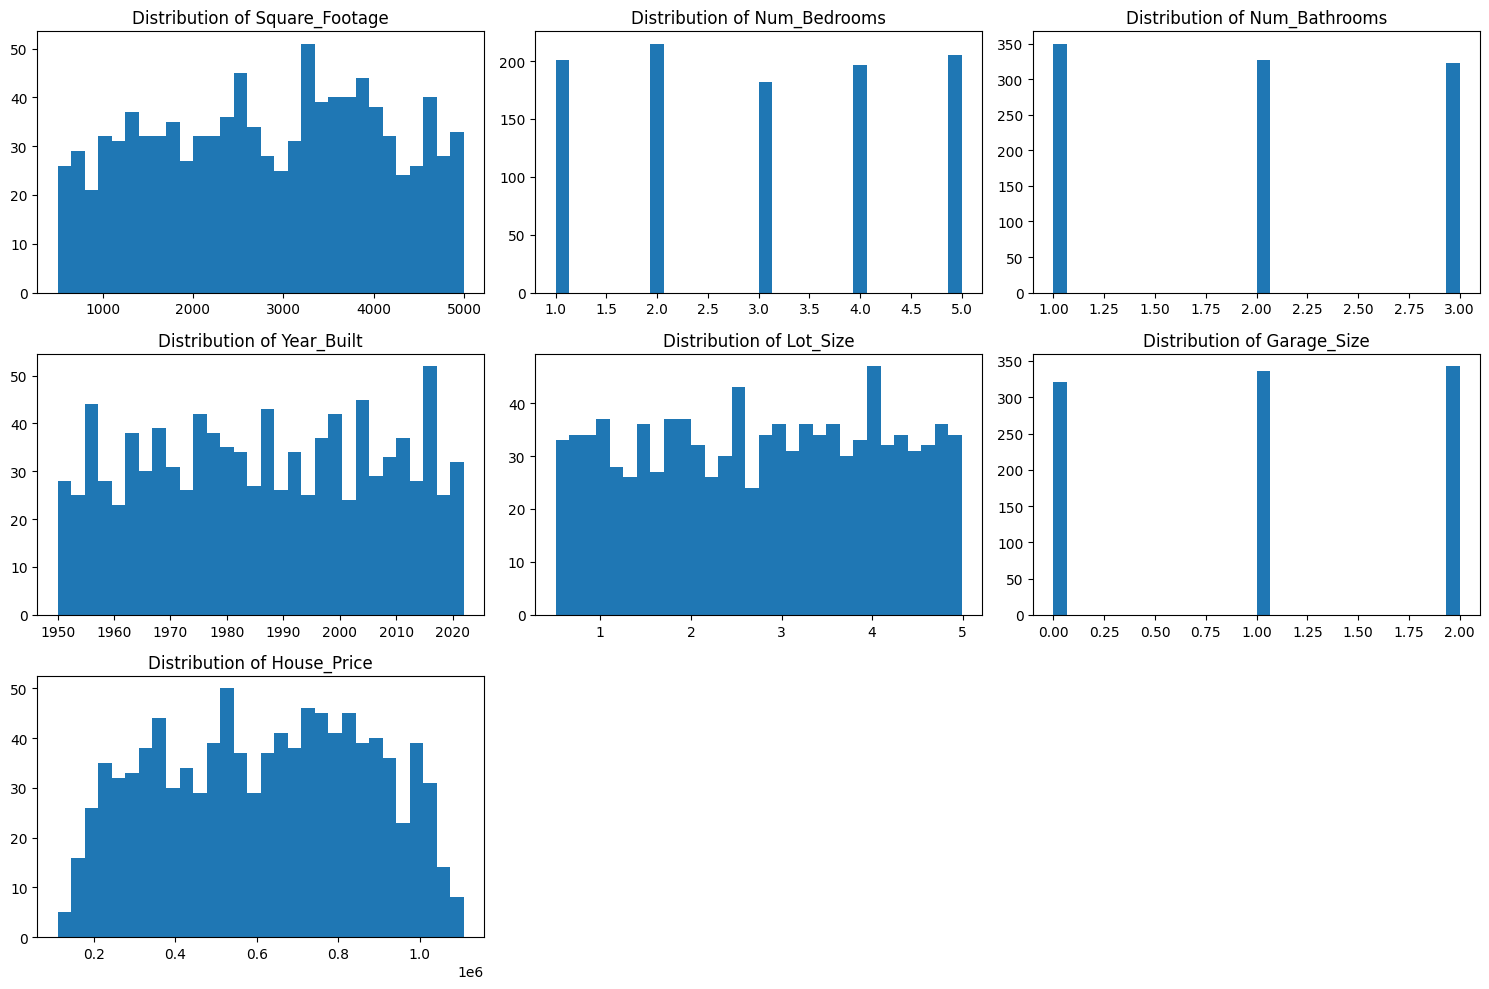

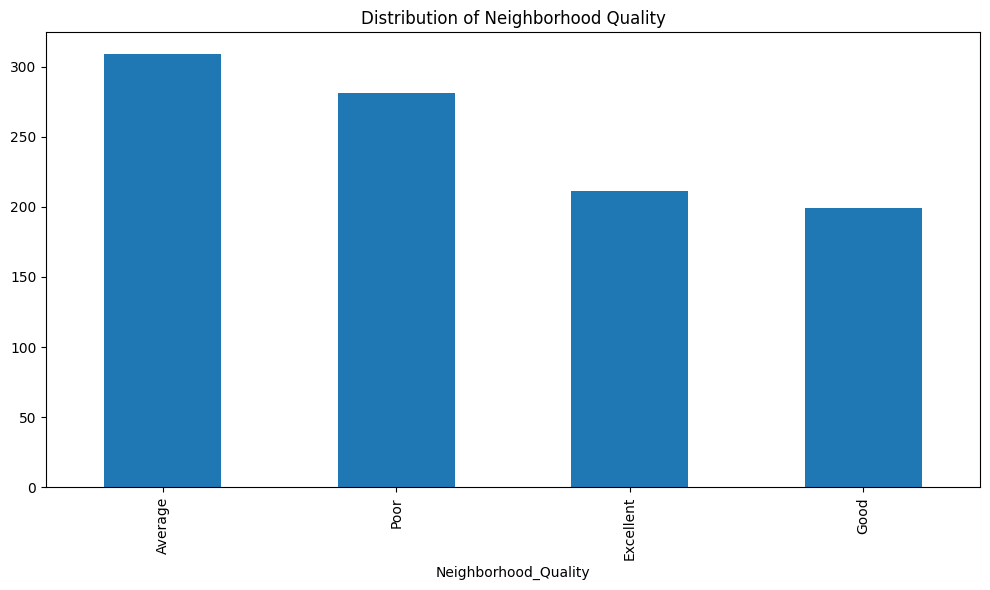

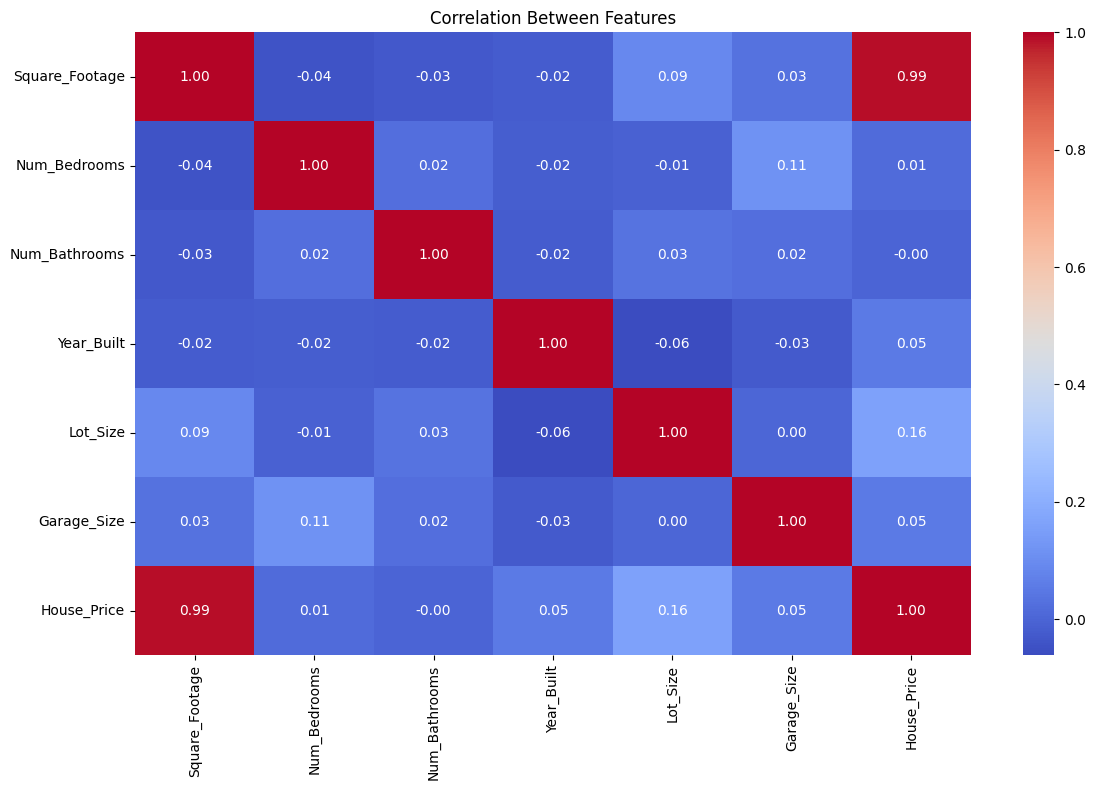

In [62]:
# Set up a larger figure for multiple plots
plt.figure(figsize=(15, 10))

# Create histograms for numerical features
for i, column in enumerate(['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms', 
                           'Year_Built', 'Lot_Size', 'Garage_Size', 'House_Price']):
    plt.subplot(3, 3, i+1)
    plt.hist(data[column], bins=30)
    plt.title(f'Distribution of {column}')
    plt.tight_layout()

plt.show()

# Check the distribution of categorical variables
plt.figure(figsize=(10, 6))
plt.subplot(1, 1, 1)
data['Neighborhood_Quality'].value_counts().plot(kind='bar')
plt.title('Distribution of Neighborhood Quality')
plt.tight_layout()
plt.show()

# Create a correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = data.drop(columns=["Neighborhood_Quality"]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Features')
plt.tight_layout()
plt.show()

Data Preprocessing and Feature Engineering

In [63]:
# Check for missing values
print(data.isnull().sum())

# Identify numerical and categorical features
numerical_features = ['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms', 
                      'Year_Built', 'Lot_Size', 'Garage_Size']
categorical_features = ['Neighborhood_Quality']

# Split the data into features and target
X = data.drop('House_Price', axis=1)
y = data['House_Price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Square_Footage          0
Num_Bedrooms            0
Num_Bathrooms           0
Year_Built              0
Lot_Size                0
Garage_Size             0
Neighborhood_Quality    0
House_Price             0
dtype: int64
Training set size: 800
Test set size: 200


Creating Preprocessing Pipelines

In [64]:
# Create preprocessing pipelines for numerical and categorical features
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(
        handle_unknown='ignore',
        sparse_output=False,  # New parameter name in scikit-learn >=1.2
        drop='first'  # Reduces multicollinearity
    ))
])


# Create a column transformer that applies the appropriate preprocessing to each column
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

# Display the preprocessing pipeline
print(preprocessor)


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Square_Footage', 'Num_Bedrooms',
                                  'Num_Bathrooms', 'Year_Built', 'Lot_Size',
                                  'Garage_Size']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Neighborhood_Quality'])])


Model Selection and Training

In [65]:
# Create a pipeline that includes preprocessing and a linear regression model
linear_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Create a pipeline with a random forest regressor
rf_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the linear regression model
linear_model_pipeline.fit(X_train, y_train)
print("Linear Regression model trained successfully.")

# Train the random forest model
rf_model_pipeline.fit(X_train, y_train)
print("Random Forest model trained successfully.")

Linear Regression model trained successfully.
Random Forest model trained successfully.


Model Evaluation

Linear Regression Metrics:
Mean Squared Error: 103421689.27
Root Mean Squared Error: 10169.65
R² Score: 0.9984

Random Forest Metrics:
Mean Squared Error: 385570347.36
Root Mean Squared Error: 19635.95
R² Score: 0.9940


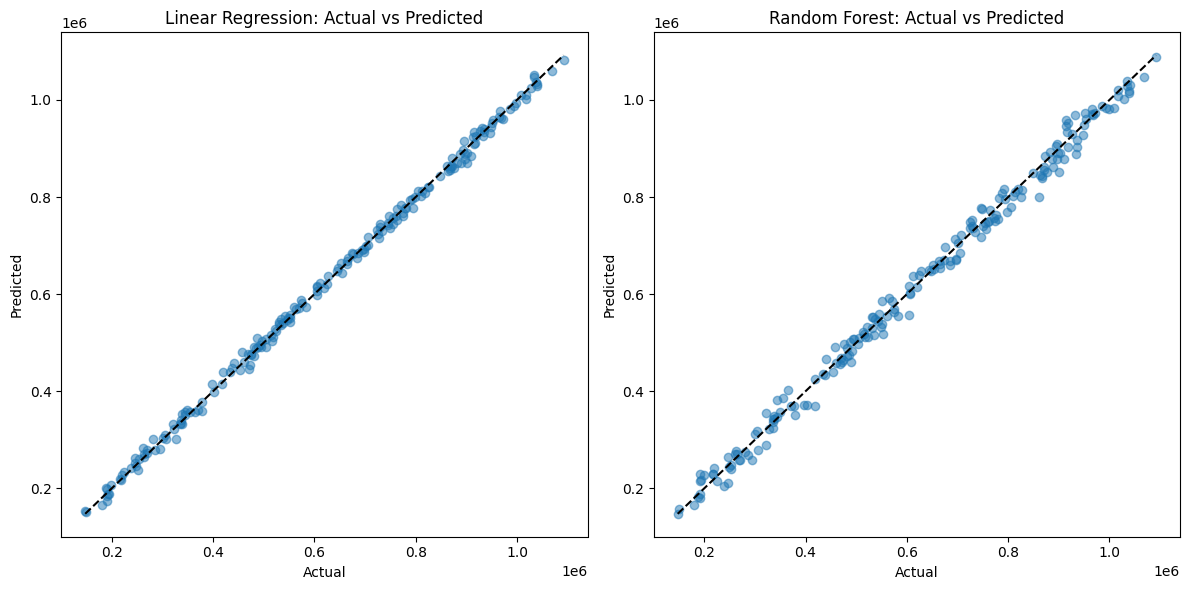

In [66]:
# Make predictions with the linear regression model
linear_predictions = linear_model_pipeline.predict(X_test)

# Make predictions with the random forest model
rf_predictions = rf_model_pipeline.predict(X_test)

# Evaluate the linear regression model
linear_mse = mean_squared_error(y_test, linear_predictions)
linear_rmse = np.sqrt(linear_mse)
linear_r2 = r2_score(y_test, linear_predictions)

print(f"Linear Regression Metrics:")
print(f"Mean Squared Error: {linear_mse:.2f}")
print(f"Root Mean Squared Error: {linear_rmse:.2f}")
print(f"R² Score: {linear_r2:.4f}")

# Evaluate the random forest model
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_predictions)

print(f"\nRandom Forest Metrics:")
print(f"Mean Squared Error: {rf_mse:.2f}")
print(f"Root Mean Squared Error: {rf_rmse:.2f}")
print(f"R² Score: {rf_r2:.4f}")

# Compare predictions vs actual values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, linear_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Linear Regression: Actual vs Predicted')

plt.subplot(1, 2, 2)
plt.scatter(y_test, rf_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest: Actual vs Predicted')

plt.tight_layout()
plt.show()

Feature Importance Analysis

9 9
                               Feature  Importance
0                  num__Square_Footage    0.986160
1                      num__Year_Built    0.005483
2                        num__Lot_Size    0.005228
3                    num__Num_Bedrooms    0.001690
4                   num__Num_Bathrooms    0.000567
5                     num__Garage_Size    0.000428
6       cat__Neighborhood_Quality_Poor    0.000159
7  cat__Neighborhood_Quality_Excellent    0.000154
8       cat__Neighborhood_Quality_Good    0.000133
                               Feature  Importance
0                  num__Square_Footage    0.986160
1                      num__Year_Built    0.005483
2                        num__Lot_Size    0.005228
3                    num__Num_Bedrooms    0.001690
4                   num__Num_Bathrooms    0.000567
5                     num__Garage_Size    0.000428
6       cat__Neighborhood_Quality_Poor    0.000159
7  cat__Neighborhood_Quality_Excellent    0.000154
8       cat__Neighborhood_Q

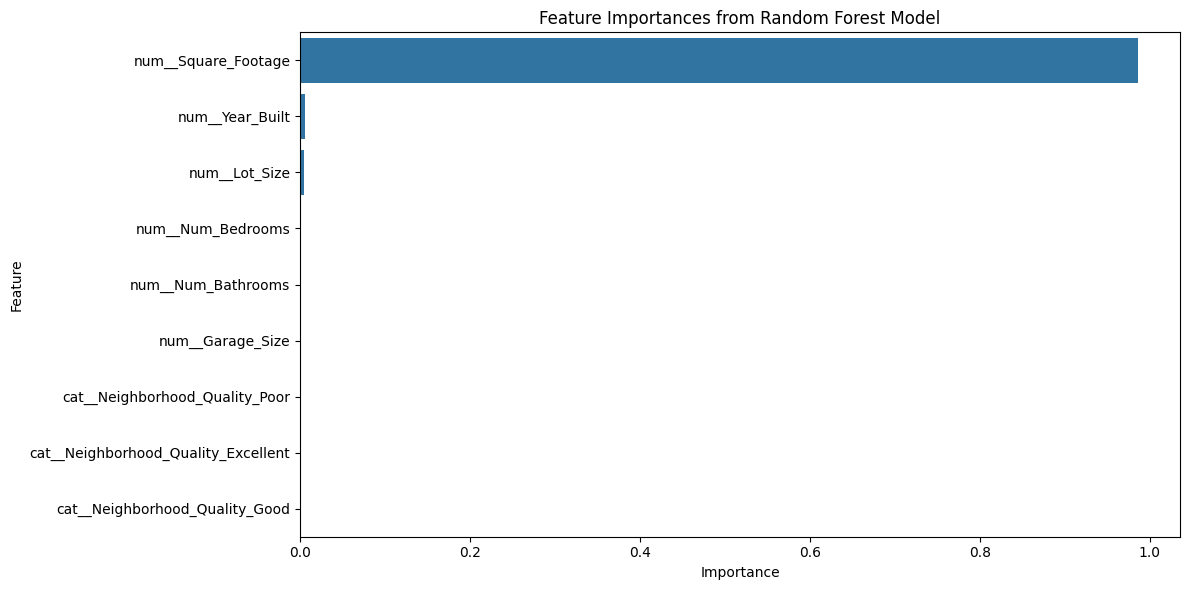

In [67]:
# Get feature names after transformation
feature_names = []
for name, _, columns in preprocessor.transformers_:
    if name == 'num':
        feature_names.extend(columns)
    elif name == 'cat':
        ohe_feature_names = []
        for col in columns:
            categories = preprocessor.named_transformers_['cat'].named_steps['encoder'].categories_[0]
            for cat in categories:
                ohe_feature_names.append(f"{col}_{cat}")
        feature_names.extend(ohe_feature_names)

# After fitting your pipeline:
rf_model_pipeline.fit(X_train, y_train)

# Extract feature names
preprocessor = rf_model_pipeline.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()

# Get importances
importances = rf_model_pipeline.named_steps['regressor'].feature_importances_

# Check lengths
print(len(feature_names), len(importances))

# Create DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False).reset_index(drop=True)

print(feature_importance_df.head(10))


# Display top 10 features
print(feature_importance_df.head(10))


# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from Random Forest Model')
plt.tight_layout()
plt.show()


Model Persistence

In [68]:
# Decide which model to save (based on performance)
# Let's assume Random Forest performed better
best_model = rf_model_pipeline

# Save the model using joblib
model_filename = 'house_price_prediction_model.joblib'
joblib.dump(best_model, model_filename)
print(f"Model saved to {model_filename}")

# Example of how to load and use the model
loaded_model = joblib.load(model_filename)

# Example prediction with the loaded model
sample_house = X_test.iloc[0:1]  # Use the first house from the test set
predicted_price = loaded_model.predict(sample_house)[0]
actual_price = y_test.iloc[0]

print(f"Sample house features: {sample_house.values[0]}")
print(f"Actual price: ${actual_price:.2f}")
print(f"Predicted price: ${predicted_price:.2f}")

Model saved to house_price_prediction_model.joblib
Sample house features: [4012 3 1 2016 2.098092415 1 'Average']
Actual price: $901000.49
Predicted price: $852460.60


Putting It All Together: A Complete Pipeline

Rf Model Evaluation:
Mean Squared Error: 399088421.32
Root Mean Squared Error: 19977.20
R² Score: 0.9938
Model saved as house_price_rf_model.joblib
Linear Model Evaluation:
Mean Squared Error: 103421689.27
Root Mean Squared Error: 10169.65
R² Score: 0.9984
Model saved as house_price_linear_model.joblib


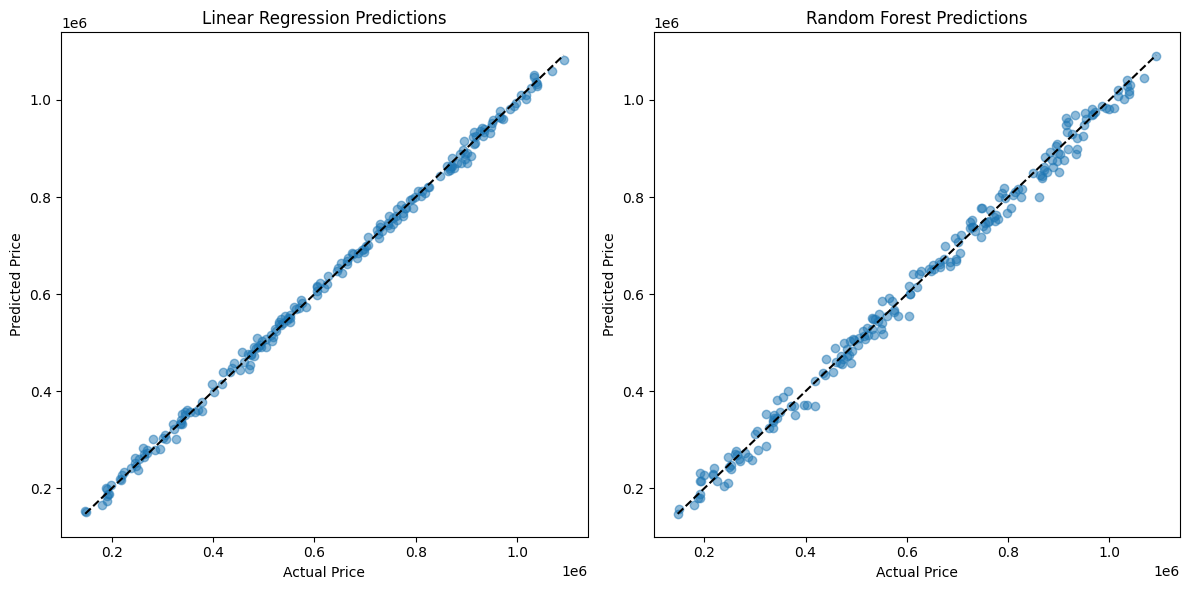

In [69]:
# Define a function to create and evaluate a complete ML pipeline
def build_evaluate_model(X_train, X_test, y_train, y_test, model_type='rf'):
    # Define preprocessing
    num_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', MinMaxScaler())
    ])
    
    cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_pipeline, ['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms', 
                                   'Year_Built', 'Lot_Size', 'Garage_Size']),
            ('cat', cat_pipeline, ['Neighborhood_Quality'])
        ])
    
    # Select model type
    if model_type == 'linear':
        model = LinearRegression()
    else:  # Default to Random Forest
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Create pipeline
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Train model
    full_pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = full_pipeline.predict(X_test)
    
    # Evaluate model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{model_type.capitalize()} Model Evaluation:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"R² Score: {r2:.4f}")
    
    # Save model
    joblib.dump(full_pipeline, f'house_price_{model_type}_model.joblib')
    print(f"Model saved as house_price_{model_type}_model.joblib")
    
    return full_pipeline, y_pred

# Build and evaluate both model types
rf_pipeline, rf_preds = build_evaluate_model(X_train, X_test, y_train, y_test, 'rf')
linear_pipeline, linear_preds = build_evaluate_model(X_train, X_test, y_train, y_test, 'linear')


# Compare model predictions visually
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, linear_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Linear Regression Predictions')

plt.subplot(1, 2, 2)
plt.scatter(y_test, rf_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Random Forest Predictions')

plt.tight_layout()
plt.show()